# Описание проекта. Телеком
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Загрузка данных

In [ ]:
!pip install phik
!pip install pytorch_tabnet
!pip install shap
!pip install optuna
!pip install seaborn

In [102]:
import random
import copy

import torch
import numpy as np
import shap
import optuna
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay

RANDOM_STATE = "05062023"
random.seed(RANDOM_STATE)

In [2]:
db_config = {
    "user": "****",  # имя пользователя,
    "pwd": "****",  # пароль,
    "host": "****",
    "port": 6432,  # порт подключения,
    "db": "****",  # название базы данных,
}

connection_string = "postgresql://{}:{}@{}:{}/{}".format(
    db_config["user"],
    db_config["pwd"],
    db_config["host"],
    db_config["port"],
    db_config["db"],
)
engine = create_engine(connection_string)

## Исследовательский анализ и предобработка данных

In [3]:
def quer(tab):
    return f"""
            SELECT *
            FROM {tab}
            LIMIT 1;
            """

In [4]:
for tab in [
    "telecom.contract",
    "telecom.personal",
    "telecom.internet",
    "telecom.phone",
]:
    sample_df = pd.read_sql_query(quer(tab), con=engine).columns
    print(tab)
    print(sample_df)
    print(len(sample_df))

telecom.contract
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
8
telecom.personal
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
5
telecom.internet
Index(['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'], dtype='object')
8
telecom.phone
Index(['c1', 'c2'], dtype='object')
2


Все таблицы присутствуют, однако названия колонок не соответствуют описанию. 

Проведем исследовательский анализ каждой таблицы: 

In [5]:
def quer_full(tab):
    return f"""
            SELECT *
            FROM {tab};
            """


contract = pd.read_sql_query(quer_full("telecom.contract"), con=engine)
personal = pd.read_sql_query(quer_full("telecom.personal"), con=engine)
internet = pd.read_sql_query(quer_full("telecom.internet"), con=engine)
phone = pd.read_sql_query(quer_full("telecom.phone"), con=engine)

In [6]:
contract.shape

(7043, 8)

In [7]:
contract.sample(3)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
5801  7718-UPSKJ  2019-07-11        None        One year              Yes   
868   3318-OSATS  2019-01-21  2019-12-01  Month-to-month              Yes   
2115  1248-DYXUB  2018-08-12        None        Two year               No   

                PaymentMethod  MonthlyCharges  TotalCharges  
5801  Credit card (automatic)          106.40       7251.90  
868          Electronic check           95.45       3474.05  
2115             Mailed check           24.80       1229.10

Приведем название столбцов к нижнему регистру.

In [8]:
contract.columns = [
    "customer_id",
    "begin_date",
    "end_date",
    "type",
    "paperless_billing",
    "payment_method",
    "monthly_charges",
    "total_charges",
]

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1869 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Пропуски имеются в колонках end_date, total_charges. В end_date указаны очевидно те случаи, когда договор не был расторгнут. 
В total_charges имеются незначительные пропуски, примем решение об их заполнении/удалении после исследования total_charges.

In [10]:
# меняем типы данных
contract["begin_date"] = pd.to_datetime(contract["begin_date"], format="%Y.%m.%d")
contract["end_date"] = pd.to_datetime(contract["end_date"], format="%Y.%m.%d")

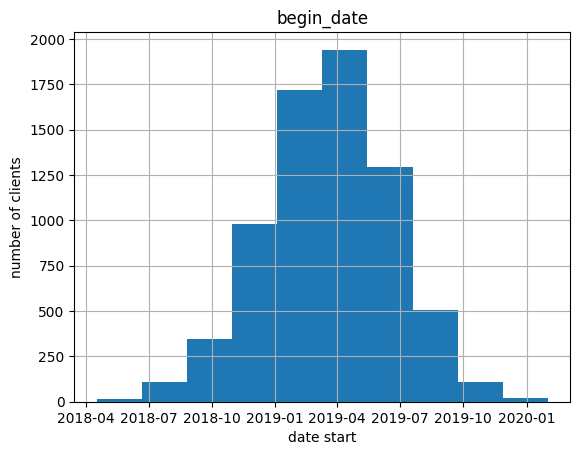

In [11]:
axarr = pd.DataFrame.hist(contract, "begin_date", sharex=True, sharey=True)
for ax in axarr.flatten():
    ax.set_xlabel("date start")
    ax.set_ylabel("number of clients")

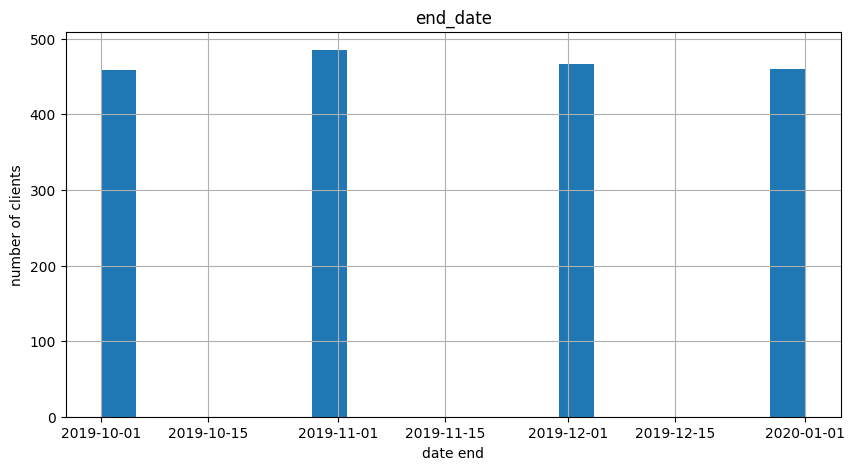

In [12]:
axarr = pd.DataFrame.hist(
    contract, "end_date", sharex=True, sharey=True, bins=20, figsize=(10, 5)
)
for ax in axarr.flatten():
    ax.set_xlabel("date end")
    ax.set_ylabel("number of clients")

In [13]:
contract.end_date.min(), contract.end_date.max()

(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

Text(0.5, 0, 'type')

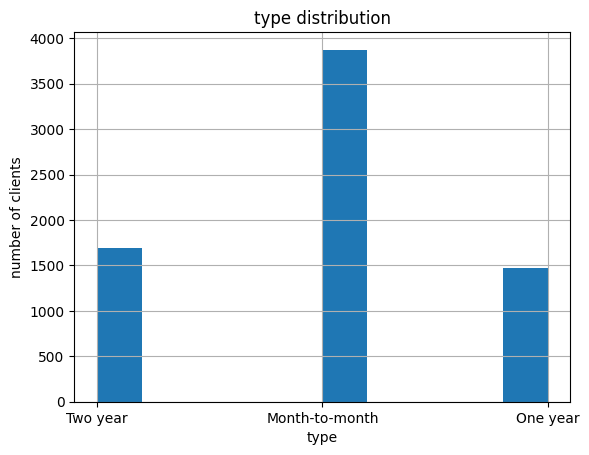

In [14]:
axarr = contract.type.hist()
axarr.title.set_text("type distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("type")

Большая часть платит раз в месяц. 

Text(0.5, 0, 'paperless_billing')

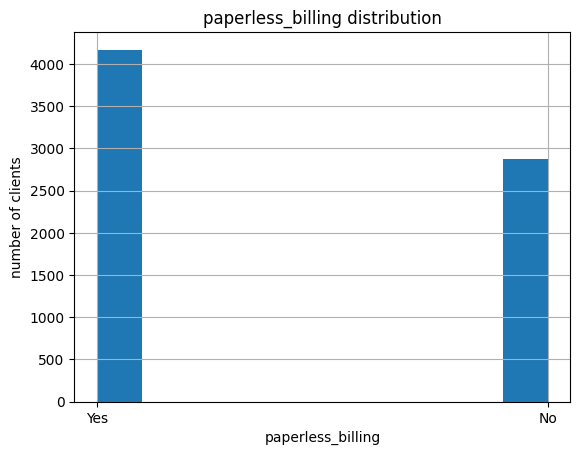

In [15]:
axarr = contract.paperless_billing.hist()
axarr.title.set_text("paperless_billing distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("paperless_billing")

Большинство предпочитает электронную форму оплаты

Text(0.5, 0, 'payment_method')

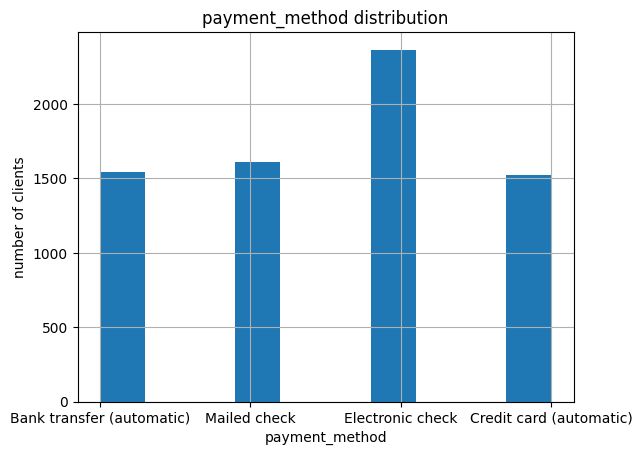

In [16]:
axarr = contract.payment_method.hist()
axarr.title.set_text("payment_method distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("payment_method")

Text(0.5, 0, 'monthly_charges')

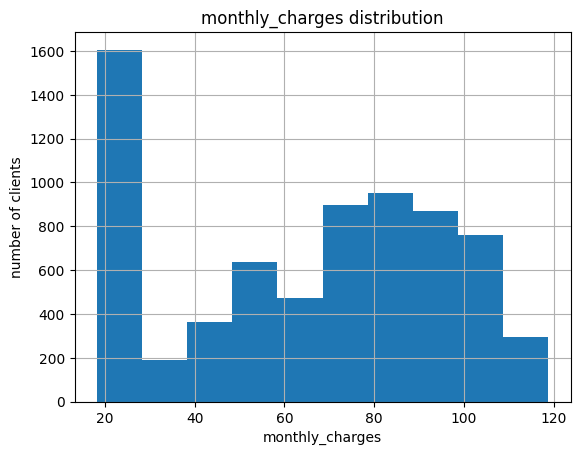

In [17]:
axarr = contract.monthly_charges.hist()
axarr.title.set_text("monthly_charges distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("monthly_charges")

In [18]:
contract.monthly_charges.mode()

0    20.05
Name: monthly_charges, dtype: float64

Большинство людей платят 20 долларов, то есть не пользуются дополнительными услугами.

Text(0.5, 0, 'total_charges')

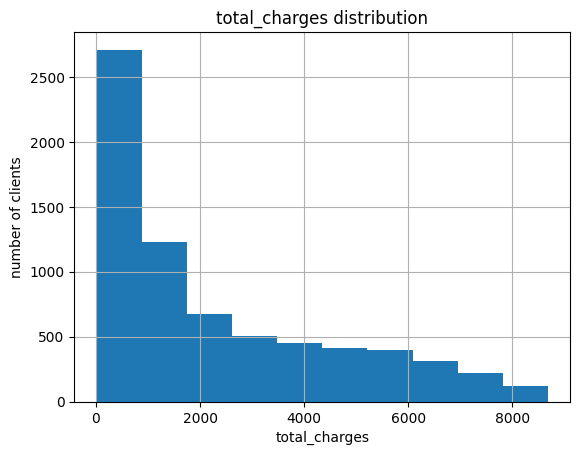

In [19]:
axarr = contract.total_charges.hist()
axarr.title.set_text("total_charges distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("total_charges")

Так как большинство использует только базовыми услугами, то и расходы за все время имеют соответствующий вид.  

In [20]:
contract.loc[contract.total_charges.isna()]

customer_id begin_date end_date      type paperless_billing  \
0     4472-LVYGI 2020-02-01      NaT  Two year               Yes   
1     3115-CZMZD 2020-02-01      NaT  Two year                No   
3     5709-LVOEQ 2020-02-01      NaT  Two year                No   
6     4367-NUYAO 2020-02-01      NaT  Two year                No   
7     1371-DWPAZ 2020-02-01      NaT  Two year                No   
9     3213-VVOLG 2020-02-01      NaT  Two year                No   
10    2923-ARZLG 2020-02-01      NaT  One year               Yes   
11    2775-SEFEE 2020-02-01      NaT  Two year               Yes   
4408  7644-OMVMY 2020-02-01      NaT  Two year                No   
5160  2520-SGTTA 2020-02-01      NaT  Two year                No   
6839  4075-WKNIU 2020-02-01      NaT  Two year                No   

                 payment_method  monthly_charges  total_charges  
0     Bank transfer (automatic)            52.55            NaN  
1                  Mailed check            20.25            NaN  
3                  Mailed check            80.85            NaN  
6                  Mailed check            25.75            NaN  
7       Credit card (automatic)            56.05            NaN  
9                  Mailed check            25.35            NaN  
10                 Mailed check            19.70            NaN  
11    Bank transfer (automatic)            61.90            NaN  
4408               Mailed check            19.85            NaN  
5160               Mailed check            20.00            NaN  
6839               Mailed check            73.35            NaN

Как видно из таблицы, у всех клиентов у которых отсутствуют сведения об общих затратах, договор не действует (нет даты окончания), и вид платежа год или два, скорее всего общая сумма затрат у них зачтется только после окончания первоначального периода оплаты. Полагаю, что логично будет засчитать один месяц использования услуг.

In [21]:
nan_rows = contract.total_charges.isna()
contract.loc[nan_rows, "total_charges"] = contract.loc[nan_rows, "monthly_charges"]

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Молодец, что заполняешь пропуски

In [22]:
contract[nan_rows]

customer_id begin_date end_date      type paperless_billing  \
0     4472-LVYGI 2020-02-01      NaT  Two year               Yes   
1     3115-CZMZD 2020-02-01      NaT  Two year                No   
3     5709-LVOEQ 2020-02-01      NaT  Two year                No   
6     4367-NUYAO 2020-02-01      NaT  Two year                No   
7     1371-DWPAZ 2020-02-01      NaT  Two year                No   
9     3213-VVOLG 2020-02-01      NaT  Two year                No   
10    2923-ARZLG 2020-02-01      NaT  One year               Yes   
11    2775-SEFEE 2020-02-01      NaT  Two year               Yes   
4408  7644-OMVMY 2020-02-01      NaT  Two year                No   
5160  2520-SGTTA 2020-02-01      NaT  Two year                No   
6839  4075-WKNIU 2020-02-01      NaT  Two year                No   

                 payment_method  monthly_charges  total_charges  
0     Bank transfer (automatic)            52.55          52.55  
1                  Mailed check            20.25          20.25  
3                  Mailed check            80.85          80.85  
6                  Mailed check            25.75          25.75  
7       Credit card (automatic)            56.05          56.05  
9                  Mailed check            25.35          25.35  
10                 Mailed check            19.70          19.70  
11    Bank transfer (automatic)            61.90          61.90  
4408               Mailed check            19.85          19.85  
5160               Mailed check            20.00          20.00  
6839               Mailed check            73.35          73.35

In [23]:
personal.sample(2)

customerID  gender  SeniorCitizen Partner Dependents
5176  0128-MKWSG  Female              0      No        Yes
5415  1310-QRITU  Female              0      No         No

In [24]:
personal.columns = ["customer_id", "gender", "senior_citizen", "partner", "dependents"]
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Text(0.5, 0, 'gender')

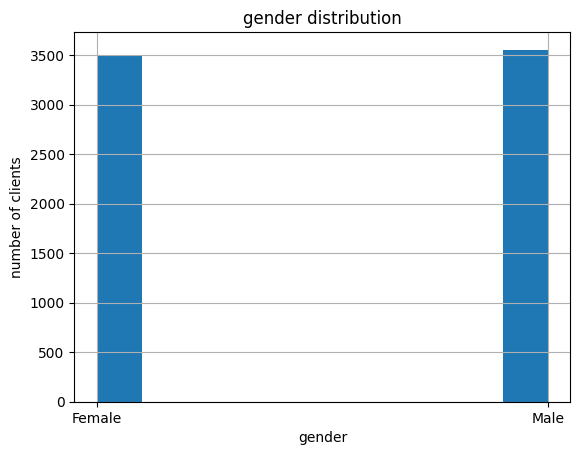

In [25]:
axarr = personal.gender.hist()
axarr.title.set_text("gender distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("gender")

In [26]:
personal.gender.value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

Соотношение мужчин и женщин практически одинаковое. 

Text(0.5, 0, 'senior_citizen')

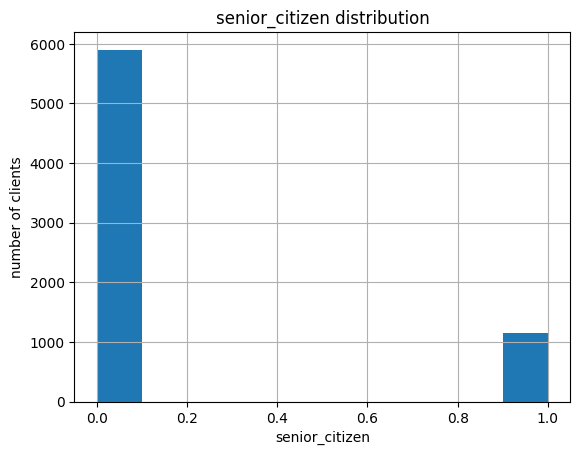

In [27]:
axarr = personal.senior_citizen.hist()
axarr.title.set_text("senior_citizen distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("senior_citizen")

Большая часть клиентов не пенсионеры. 

Text(0.5, 0, 'partner')

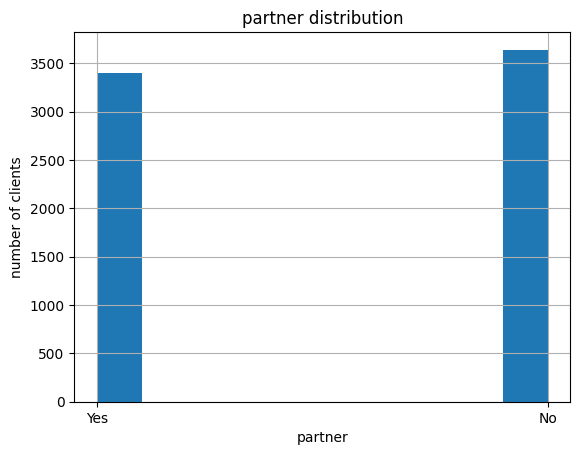

In [28]:
axarr = personal.partner.hist()
axarr.title.set_text("partner distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("partner")

Большая часть клиентов не состоит в браке.

Text(0.5, 0, 'dependents')

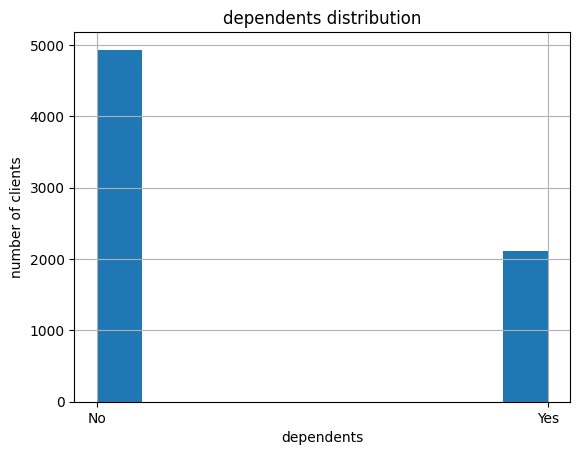

In [29]:
axarr = personal.dependents.hist()
axarr.title.set_text("dependents distribution")
axarr.yaxis.set_label_text("number of clients")
axarr.xaxis.set_label_text("dependents")

У большинства клиентов детей не имеется. 

In [30]:
internet.head(3)

c1               c2              c3            c4  \
0  customerID  InternetService  OnlineSecurity  OnlineBackup   
1  7590-VHVEG              DSL              No           Yes   
2  5575-GNVDE              DSL             Yes            No   

                 c5           c6           c7               c8  
0  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
1                No           No           No               No  
2               Yes           No           No               No

In [31]:
internet_new = internet[1:]
internet_new.columns = [
    "customer_id",
    "internet_service",
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
]

In [32]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


пропусков не имеется

Text(0.5, 0, 'internet_service')

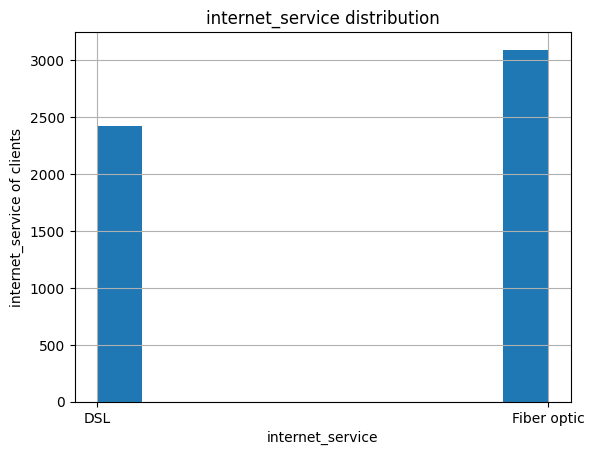

In [33]:
axarr = internet_new.internet_service.hist()
axarr.title.set_text("internet_service distribution")
axarr.yaxis.set_label_text("internet_service of clients")
axarr.xaxis.set_label_text("internet_service")

Большинство пользователей использует оптоволоконный кабель 

Text(0.5, 0, 'online_security')

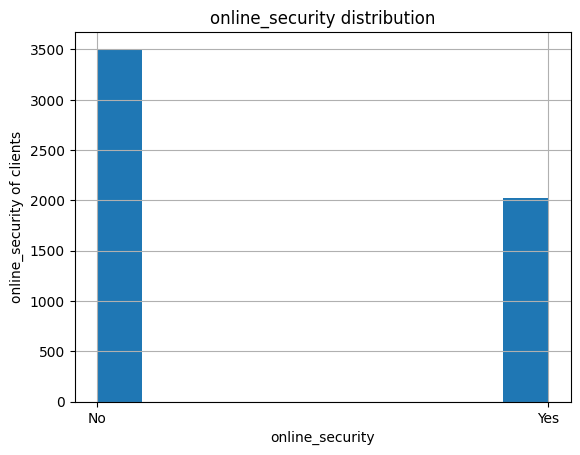

In [34]:
axarr = internet_new.online_security.hist()
axarr.title.set_text("online_security distribution")
axarr.yaxis.set_label_text("online_security of clients")
axarr.xaxis.set_label_text("online_security")

In [35]:
internet_new.online_security.value_counts(normalize=True)

online_security
No     0.63404
Yes    0.36596
Name: proportion, dtype: float64

Только 36 процентов клиентов пользуются услугой по блокировке опасных сайтов. 

online_backup
No     0.559724
Yes    0.440276
Name: proportion, dtype: float64

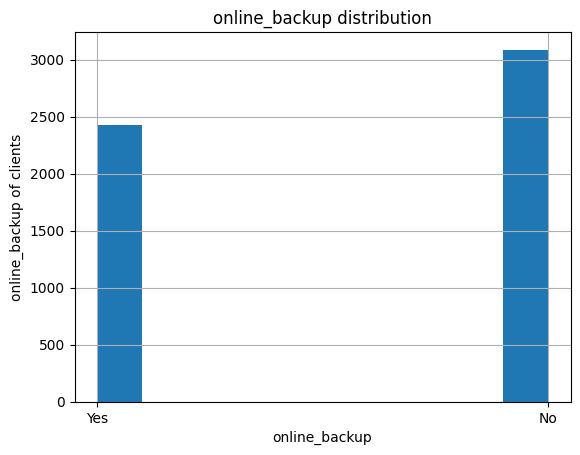

In [36]:
axarr = internet_new.online_backup.hist()
axarr.title.set_text("online_backup distribution")
axarr.yaxis.set_label_text("online_backup of clients")
axarr.xaxis.set_label_text("online_backup")
internet_new.online_backup.value_counts(normalize=True)

Только 44 процента клиентов пользуются облачным хранилищем файлов для резервного копирования данных. 

device_protection
No     0.560993
Yes    0.439007
Name: proportion, dtype: float64

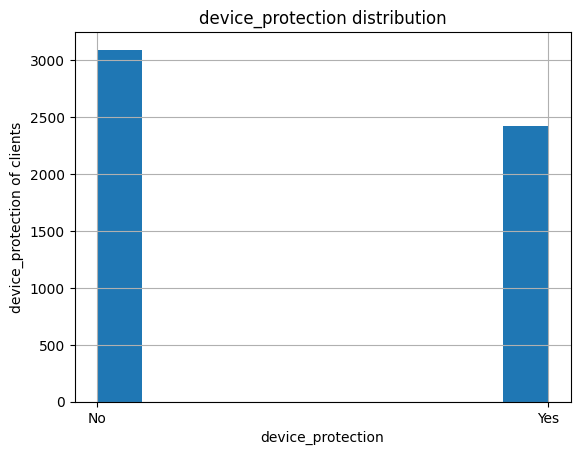

In [37]:
axarr = internet_new.device_protection.hist()
axarr.title.set_text("device_protection distribution")
axarr.yaxis.set_label_text("device_protection of clients")
axarr.xaxis.set_label_text("device_protection")
internet_new.device_protection.value_counts(normalize=True)

Только 43 процента клиентов пользуются антивирусом компании. 

tech_support
No     0.629509
Yes    0.370491
Name: proportion, dtype: float64

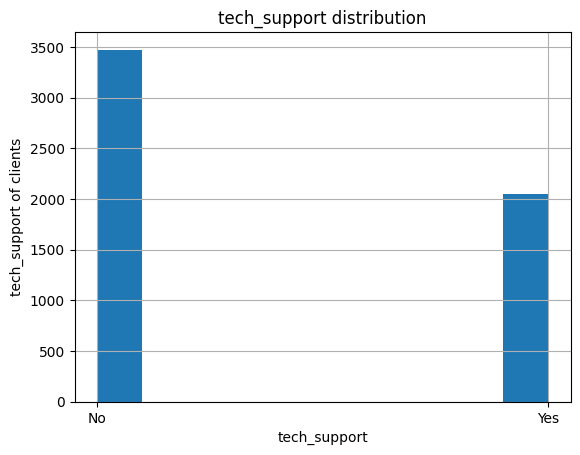

In [38]:
axarr = internet_new.tech_support.hist()
axarr.title.set_text("tech_support distribution")
axarr.yaxis.set_label_text("tech_support of clients")
axarr.xaxis.set_label_text("tech_support")
internet_new.tech_support.value_counts(normalize=True)

Только 37 процентов пользуется выделенной линией технической поддержки.

streaming_tv
No     0.509335
Yes    0.490665
Name: proportion, dtype: float64

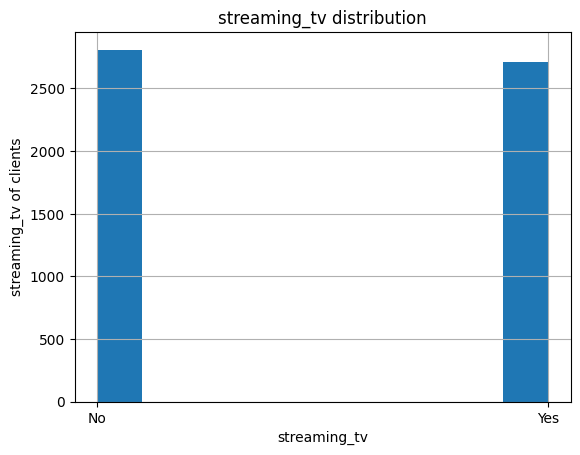

In [39]:
axarr = internet_new.streaming_tv.hist()
axarr.title.set_text("streaming_tv distribution")
axarr.yaxis.set_label_text("streaming_tv of clients")
axarr.xaxis.set_label_text("streaming_tv")
internet_new.streaming_tv.value_counts(normalize=True)

49 процентов клиентов пользуется стриминговым телевидением

streaming_movies
No     0.504803
Yes    0.495197
Name: proportion, dtype: float64

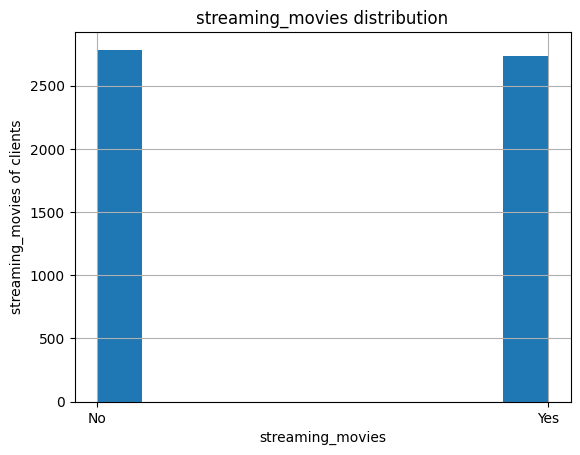

In [40]:
axarr = internet_new.streaming_movies.hist()
axarr.title.set_text("streaming_movies distribution")
axarr.yaxis.set_label_text("streaming_movies of clients")
axarr.xaxis.set_label_text("streaming_movies")
internet_new.streaming_movies.value_counts(normalize=True)

49 процентов клиентов пользуется каталогом фильмов

In [41]:
phone.head(3)

c1             c2
0  customerID  MultipleLines
1  5575-GNVDE             No
2  3668-QPYBK             No

In [42]:
phone_new = phone[1:]
phone_new.columns = ["customer_id", "multiple_lines"]

multiple_lines
No     0.532935
Yes    0.467065
Name: proportion, dtype: float64

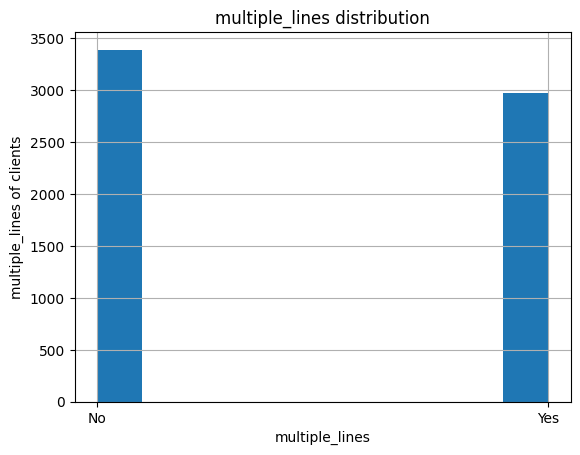

In [43]:
axarr = phone_new.multiple_lines.hist()
axarr.title.set_text("multiple_lines distribution")
axarr.yaxis.set_label_text("multiple_lines of clients")
axarr.xaxis.set_label_text("multiple_lines")
phone_new.multiple_lines.value_counts(normalize=True)

В итоге у нас получаются такие таблицы: 

In [44]:
contract.sample(3)

customer_id begin_date   end_date            type paperless_billing  \
1492  2344-JMOGN 2019-02-13 2019-10-01  Month-to-month               Yes   
6133  4815-GBTCD 2019-06-05        NaT  Month-to-month               Yes   
4297  2874-YXVVA 2019-03-28        NaT  Month-to-month               Yes   

        payment_method  monthly_charges  total_charges  
1492      Mailed check            94.85         890.60  
6133  Electronic check            25.15          99.95  
4297  Electronic check           105.10        3634.80

In [45]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [46]:
personal.sample(3)

customer_id  gender  senior_citizen partner dependents
1411  2692-BUCFV    Male               1      No         No
3768  3537-HPKQT  Female               0     Yes         No
1615  2812-REYAT  Female               0     Yes         No

In [47]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [48]:
internet_new.sample(3)

customer_id internet_service online_security online_backup  \
2312  2845-AFFTX      Fiber optic              No            No   
2630  7109-CQYUZ              DSL             Yes           Yes   
2039  8325-QRPZR      Fiber optic              No            No   

     device_protection tech_support streaming_tv streaming_movies  
2312               Yes           No          Yes              Yes  
2630               Yes          Yes          Yes              Yes  
2039               Yes           No           No               No

In [49]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [50]:
phone_new.sample(3)

customer_id multiple_lines
6107  2775-SEFEE            Yes
886   6646-QVXLR            Yes
872   4849-PYRLQ            Yes

In [51]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
По результатам анализа можно сделать следующий вывод: 
- большая клиентов осуществляет ежемесячную оплату;

- большинство предпочитает электронную форму оплаты;

- большинство людей платят 20 долларов, то есть не пользуются дополнительными услугами; 
- среди клиентов соотношение мужчин и женщин практически одинаковое; 
- большая часть клиентов не пенсионеры; 
- большая часть клиентов не состоит в браке; 
- у большинства клиентов детей не имеется; 
- большинство пользователей использует оптоволоконный кабель; 
- только 36 процентов клиентов пользуются услугой по блокировке опасных сайтов; 
- только 44 процента клиентов пользуются облачным хранилищем файлов для резервного копирования данных; 
- только 43 процента клиентов пользуются антивирусом компании; 
- только 37 процентов пользуется выделенной линией технической поддержки; 
- 49 процентов клиентов пользуется стриминговым телевидением; 
- 49 процентов клиентов пользуется каталогом фильмов.  


## Объеденение таблиц 

In [52]:
df = contract.merge(personal, on="customer_id", how="left")
df = df.merge(internet_new, on="customer_id", how="left")
df = df.merge(phone_new, on="customer_id", how="left")
df

customer_id begin_date   end_date            type paperless_billing  \
0     4472-LVYGI 2020-02-01        NaT        Two year               Yes   
1     3115-CZMZD 2020-02-01        NaT        Two year                No   
2     3668-QPYBK 2018-08-09 2019-12-01  Month-to-month               Yes   
3     5709-LVOEQ 2020-02-01        NaT        Two year                No   
4     9237-HQITU 2019-01-26 2019-11-01  Month-to-month               Yes   
...          ...        ...        ...             ...               ...   
7038  2569-WGERO 2019-01-21        NaT        Two year               Yes   
7039  6840-RESVB 2019-02-26        NaT        One year               Yes   
7040  2234-XADUH 2019-09-02        NaT        One year               Yes   
7041  4801-JZAZL 2019-06-26        NaT  Month-to-month               Yes   
7042  3186-AJIEK 2019-04-18        NaT        Two year               Yes   

                 payment_method  monthly_charges  total_charges  gender  \
0     Bank transfer (automatic)            52.55          52.55  Female   
1                  Mailed check            20.25          20.25    Male   
2                  Mailed check            53.85         108.15    Male   
3                  Mailed check            80.85          80.85  Female   
4              Electronic check            70.70         151.65  Female   
...                         ...              ...            ...     ...   
7038  Bank transfer (automatic)            21.15        1419.40  Female   
7039               Mailed check            84.80        1990.50    Male   
7040    Credit card (automatic)           103.20        7362.90  Female   
7041           Electronic check            29.60         346.45  Female   
7042  Bank transfer (automatic)           105.65        6844.50    Male   

      senior_citizen partner dependents internet_service online_security  \
0                  0     Yes        Yes              DSL             Yes   
1                  0      No        Yes              NaN             NaN   
2                  0      No         No              DSL             Yes   
3                  0     Yes        Yes              DSL             Yes   
4                  0      No         No      Fiber optic              No   
...              ...     ...        ...              ...             ...   
7038               0      No         No              NaN             NaN   
7039               0     Yes        Yes              DSL             Yes   
7040               0     Yes        Yes      Fiber optic              No   
7041               0     Yes        Yes              DSL             Yes   
7042               0      No         No      Fiber optic             Yes   

     online_backup device_protection tech_support streaming_tv  \
0               No               Yes          Yes          Yes   
1              NaN               NaN          NaN          NaN   
2              Yes                No           No           No   
3              Yes               Yes           No          Yes   
4               No                No           No           No   
...            ...               ...          ...          ...   
7038           NaN               NaN          NaN          NaN   
7039            No               Yes          Yes          Yes   
7040           Yes               Yes           No          Yes   
7041            No                No           No           No   
7042            No               Yes          Yes          Yes   

     streaming_movies multiple_lines  
0                  No            NaN  
1                 NaN             No  
2                  No             No  
3                 Yes             No  
4                  No             No  
...               ...            ...  
7038              NaN             No  
7039              Yes            Yes  
7040              Yes            Yes  
7041               No            NaN  
7042              Yes             No  

[7043 rows x 20 

In [53]:
df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [54]:
df_null = df[df.internet_service.isna()]
df_null.isna().sum()

customer_id             0
begin_date              0
end_date             1413
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines          0
dtype: int64

В результате объединения образовались записи, в которых нет информации о предоставляемых услугах, а также пропуски в multiple_lines. 

Полагаю, что перечень услуг целесообразно устанавливать через месячную оплату.

<Axes: >

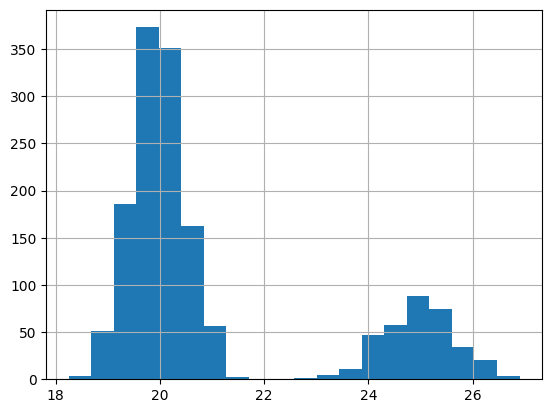

In [55]:
df_null.monthly_charges.hist(bins=20)

In [56]:
df_null.monthly_charges.describe()

count    1526.000000
mean       21.079194
std         2.164221
min        18.250000
25%        19.700000
50%        20.150000
75%        20.900000
max        26.900000
Name: monthly_charges, dtype: float64

Как видно из представленного графика ежемесячная оплата пользователей составляла от 18 до 27 долларов. Теперь посмотрим, какими услугами пользуются клиенты с такой абонентской платой. 

In [57]:
df_not_null = df[~df.internet_service.isna()]
little_charges = (df_not_null.monthly_charges > 18) & (df_not_null.monthly_charges < 27)
sum(little_charges)

80

In [58]:
pd.pivot_table(
    df_not_null[little_charges],
    index=[
        "internet_service",
        "online_security",
        "online_backup",
        "device_protection",
        "tech_support",
        "streaming_tv",
        "streaming_movies",
    ],
    values=["customer_id"],
    aggfunc="count",
    margins=True,
)

customer_id
internet_service online_security online_backup device_protection tech_support streaming_tv streaming_movies             
DSL              No              No            No                No           No           No                         80
All                                                                                                                   80

Как видно из представленной таблицы клиенты с такой ежемесячной платой используют только интернет, причем только DSL.

In [59]:
df.multiple_lines.value_counts()

multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

Услуга multiple_lines довольно редкая, поэтому заполним пропуски на No. 

In [60]:
# выделим отдельно end_date чтобы не заполнить там пропуски
end_date = df.end_date

df.internet_service = df.internet_service.fillna("DSL")

# остальные пропуски заполним No
df.fillna("No", inplace=True)

df.end_date = end_date

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Выделим отдельную колонку для признака ушел/остался

In [62]:
df["go_out"] = ~df.end_date.isna()
df["go_out"] = df.go_out.apply(lambda x: 1 if x else 0)

In [63]:
df.go_out.value_counts()

go_out
0    5174
1    1869
Name: count, dtype: int64

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'go_out']


The number of unique values of variable customer_id is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_id can be slow.
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3627145. Are interval variables set correctly?
  warnings.warn(


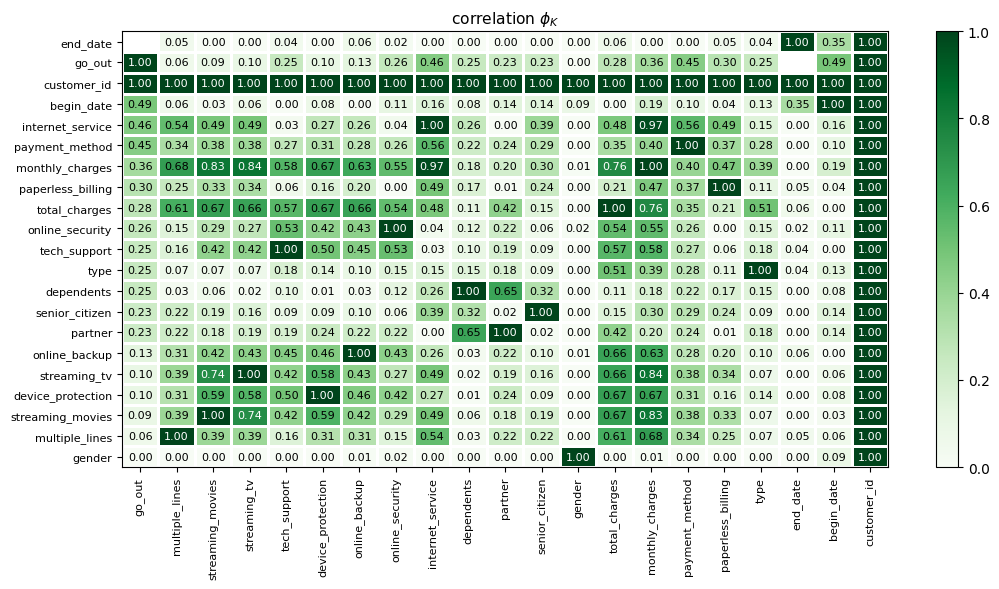

In [64]:
phik_overview = df.phik_matrix().round(2).sort_values("go_out")

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Greens",
    title=r"correlation $\phi_K$",
    fontsize_factor=0.8,
    figsize=(11, 6),
)
plt.tight_layout()

Имеется корреляция с tech_support, online_security, internet_service, dependents, partner, senior_citizen, total_charges, monthly_charges, payment_method, paperless_billing, begin_date


Теперь посмотрим на статистическую значимость (логарифмическую вероятность): 

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'go_out']


The number of unique values of variable customer_id is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_id can be slow.
Too few unique values for variable end_date (4) or go_out (1) to calculate significance


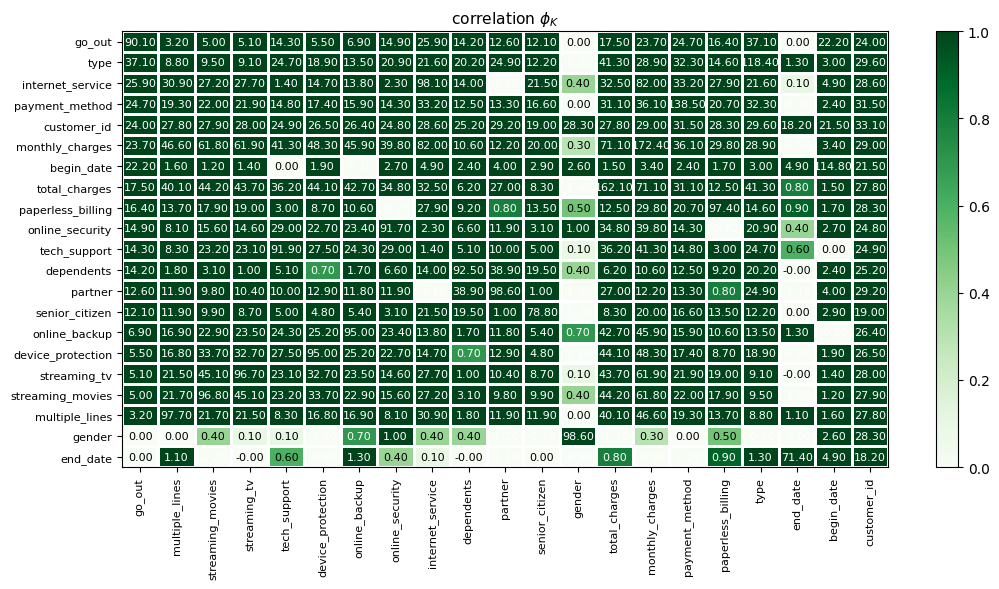

In [65]:
phik_overview = df.significance_matrix().fillna(0).round(1).sort_values("go_out")

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Greens",
    title=r"correlation $\phi_K$",
    fontsize_factor=0.8,
    figsize=(11, 6),
)
plt.tight_layout()

Так как среди всех отмеченных ранее признаков, коррелирующих с go_out логарифмическая вероятность больше 3.84, то есть p < 0.01, то все их необходимо исследовать в разрезе go_out. 

In [66]:
columns = [
    "tech_support",
    "online_security",
    "internet_service",
    "dependents",
    "partner",
    "senior_citizen",
    "total_charges",
    "monthly_charges",
    "payment_method",
    "paperless_billing",
    "begin_date",
]

In [67]:
def yes_no_plot(column: str):
    g = sns.displot(
        data=df, x=column, hue="go_out", legend=True, aspect=4, kind="hist", alpha=0.5
    )
    df_budder = df[[column, "go_out"]]

    print(df_budder[df_budder.go_out == 1].value_counts(normalize=True))
    print(df_budder[df_budder.go_out == 0].value_counts(normalize=True))
    plt.title(f"{column} in section go_out")
    plt.show()

Как видно из представленных выше графика и таблиц 

tech_support  go_out
No            1         0.834136
Yes           1         0.165864
Name: proportion, dtype: float64
tech_support  go_out
No            0         0.664863
Yes           0         0.335137
Name: proportion, dtype: float64


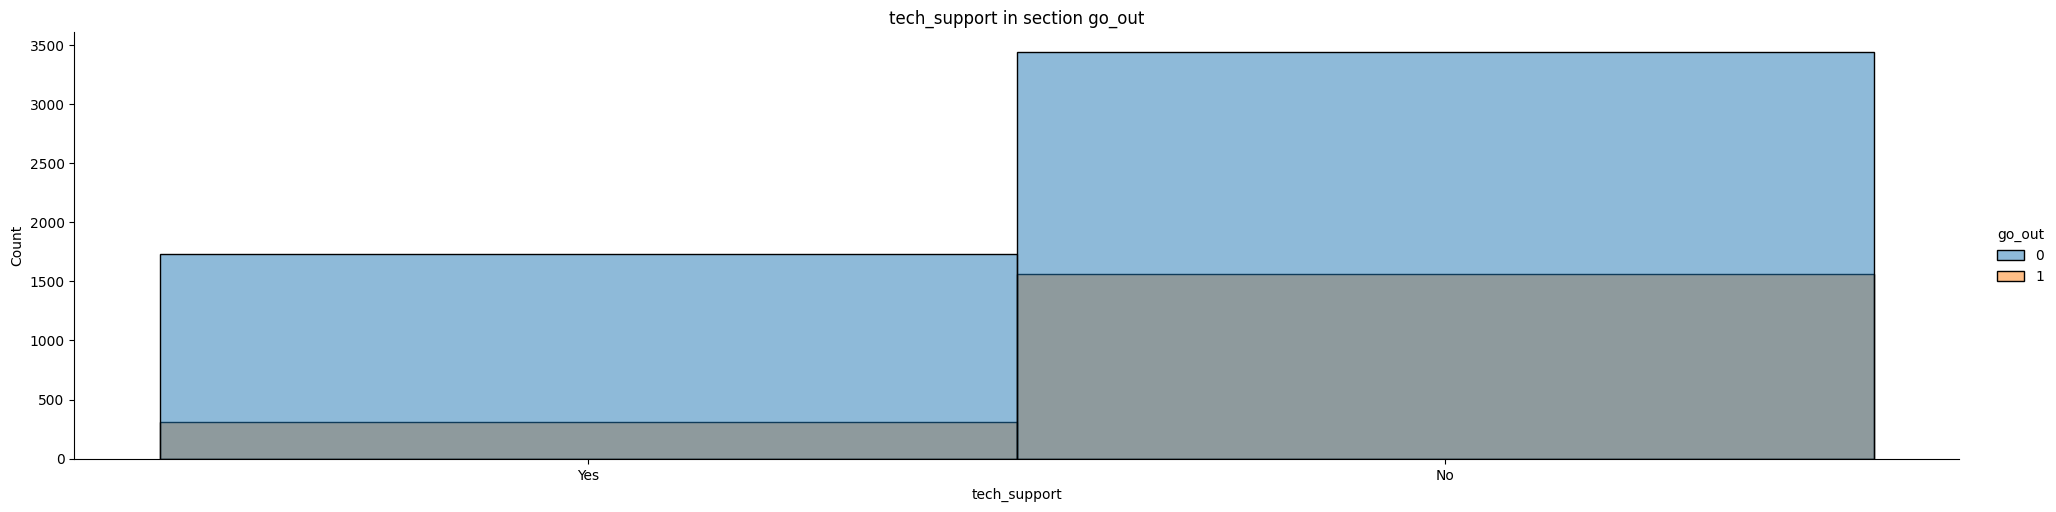

online_security  go_out
No               1         0.842162
Yes              1         0.157838
Name: proportion, dtype: float64
online_security  go_out
No               0         0.666796
Yes              0         0.333204
Name: proportion, dtype: float64


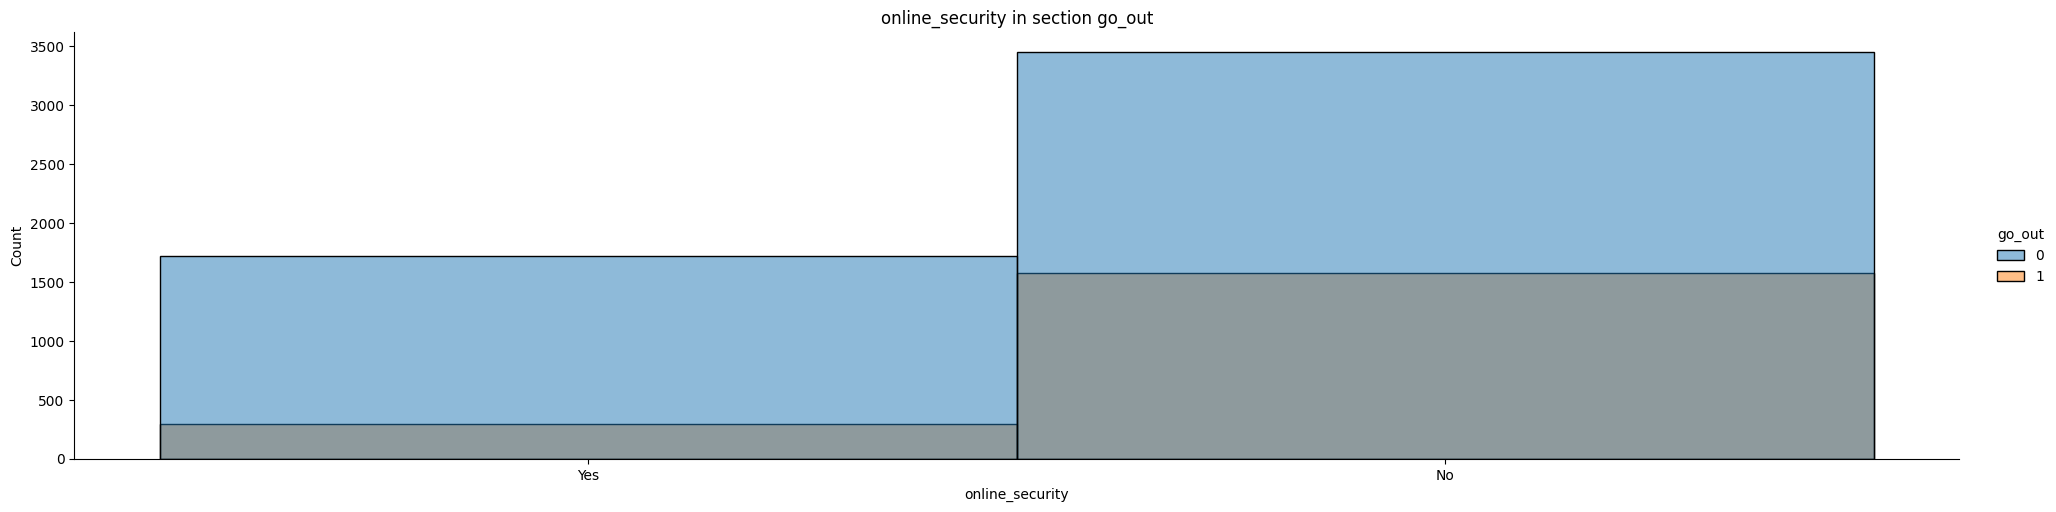

internet_service  go_out
Fiber optic       1         0.693954
DSL               1         0.306046
Name: proportion, dtype: float64
internet_service  go_out
DSL               0         0.6523
Fiber optic       0         0.3477
Name: proportion, dtype: float64


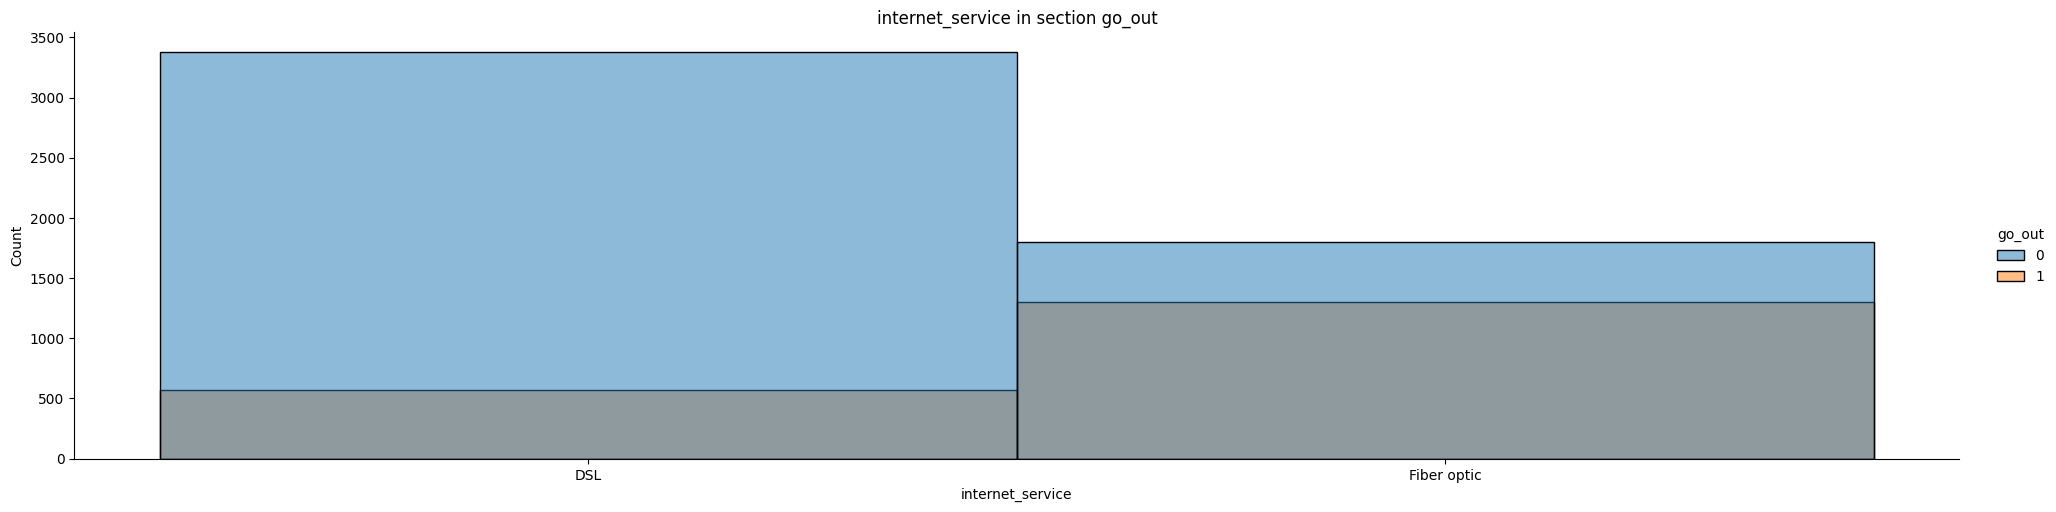

dependents  go_out
No          1         0.825575
Yes         1         0.174425
Name: proportion, dtype: float64
dependents  go_out
No          0         0.655199
Yes         0         0.344801
Name: proportion, dtype: float64


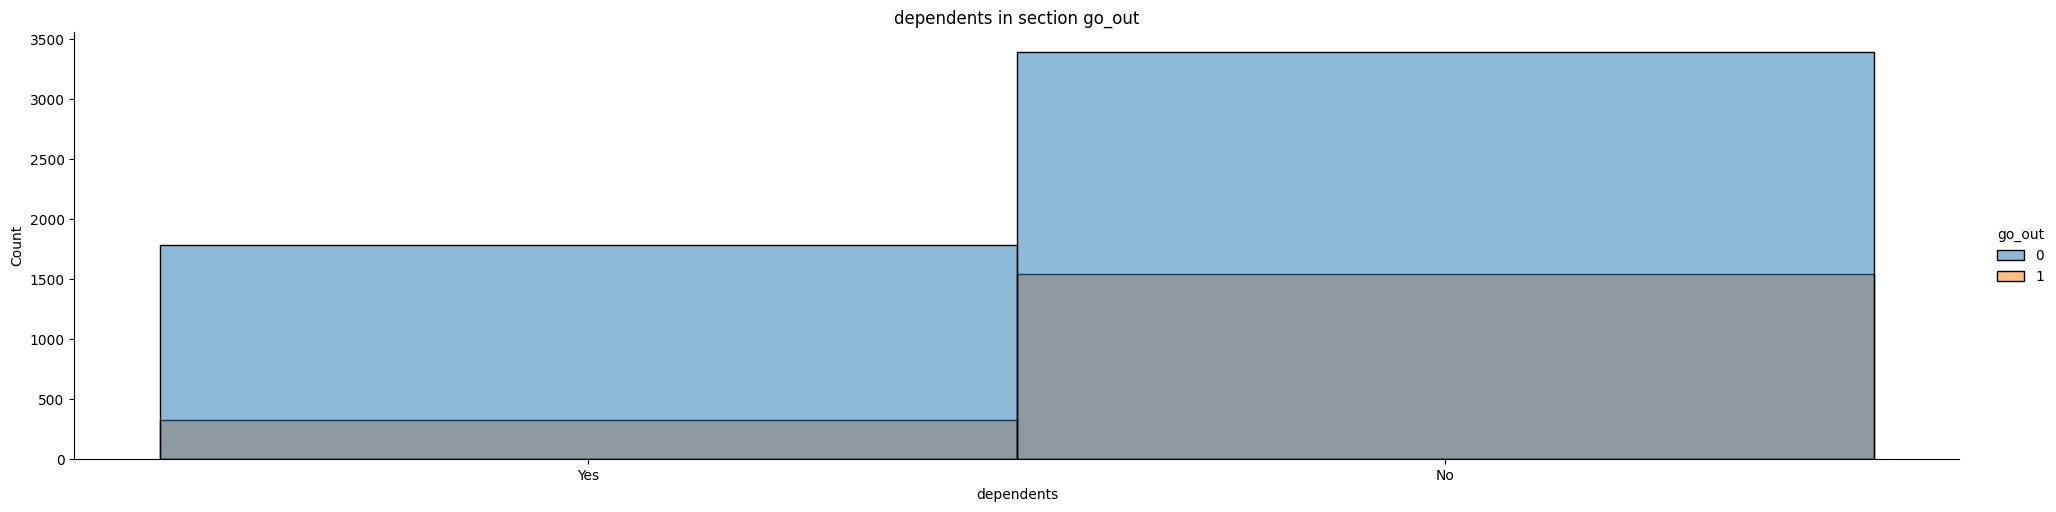

partner  go_out
No       1         0.642055
Yes      1         0.357945
Name: proportion, dtype: float64
partner  go_out
Yes      0         0.528218
No       0         0.471782
Name: proportion, dtype: float64


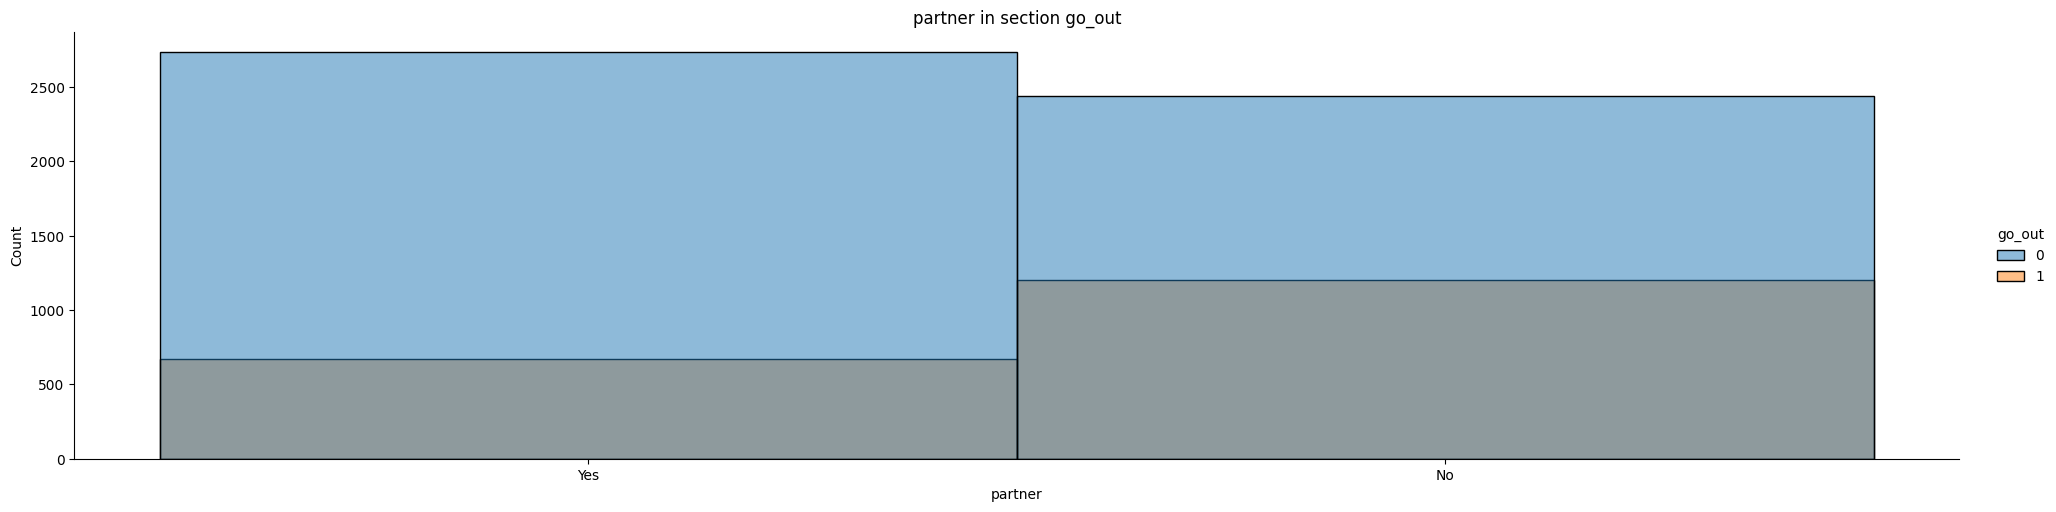

senior_citizen  go_out
0               1         0.745318
1               1         0.254682
Name: proportion, dtype: float64
senior_citizen  go_out
0               0         0.871279
1               0         0.128721
Name: proportion, dtype: float64


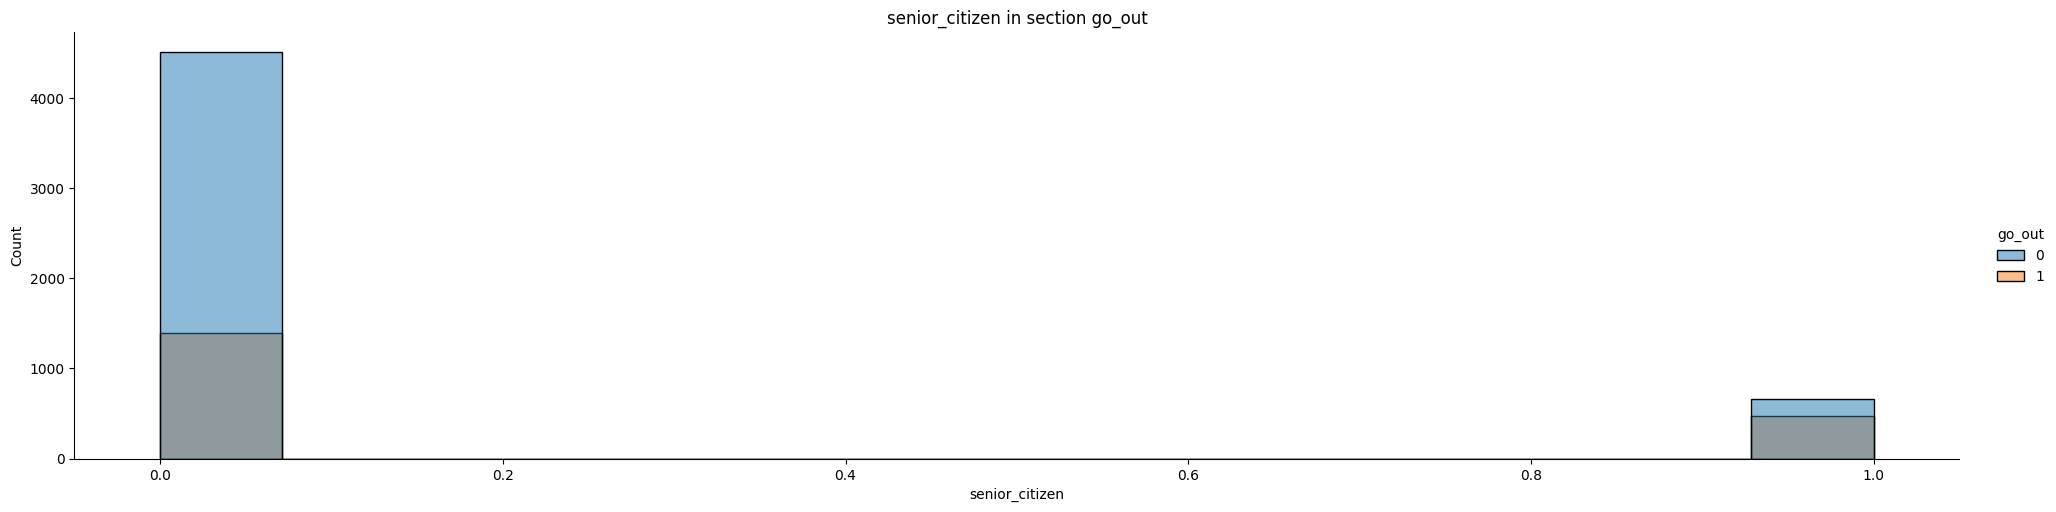

payment_method             go_out
Electronic check           1         0.573034
Mailed check               1         0.164794
Bank transfer (automatic)  1         0.138042
Credit card (automatic)    1         0.124131
Name: proportion, dtype: float64
payment_method             go_out
Mailed check               0         0.252029
Electronic check           0         0.250097
Credit card (automatic)    0         0.249324
Bank transfer (automatic)  0         0.248550
Name: proportion, dtype: float64


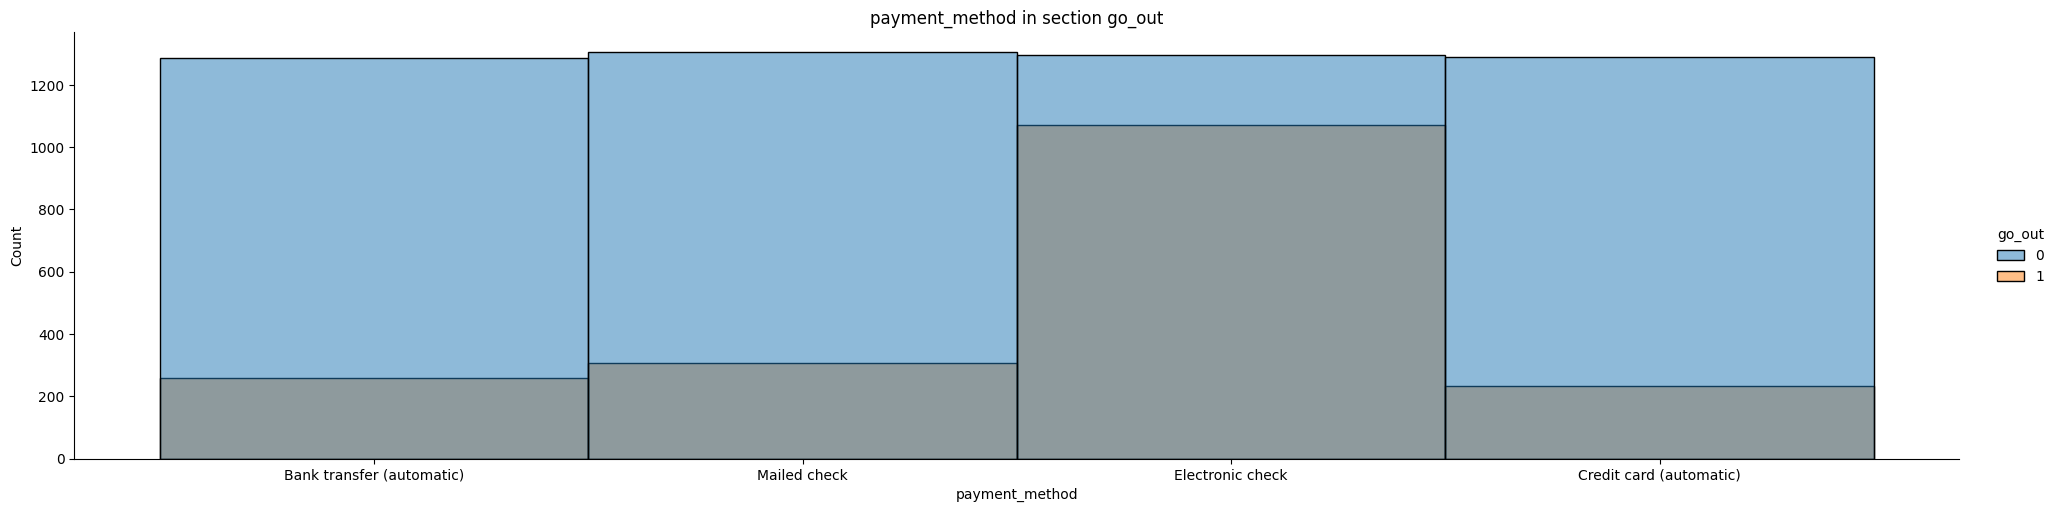

paperless_billing  go_out
Yes                1         0.749064
No                 1         0.250936
Name: proportion, dtype: float64
paperless_billing  go_out
Yes                0         0.535562
No                 0         0.464438
Name: proportion, dtype: float64


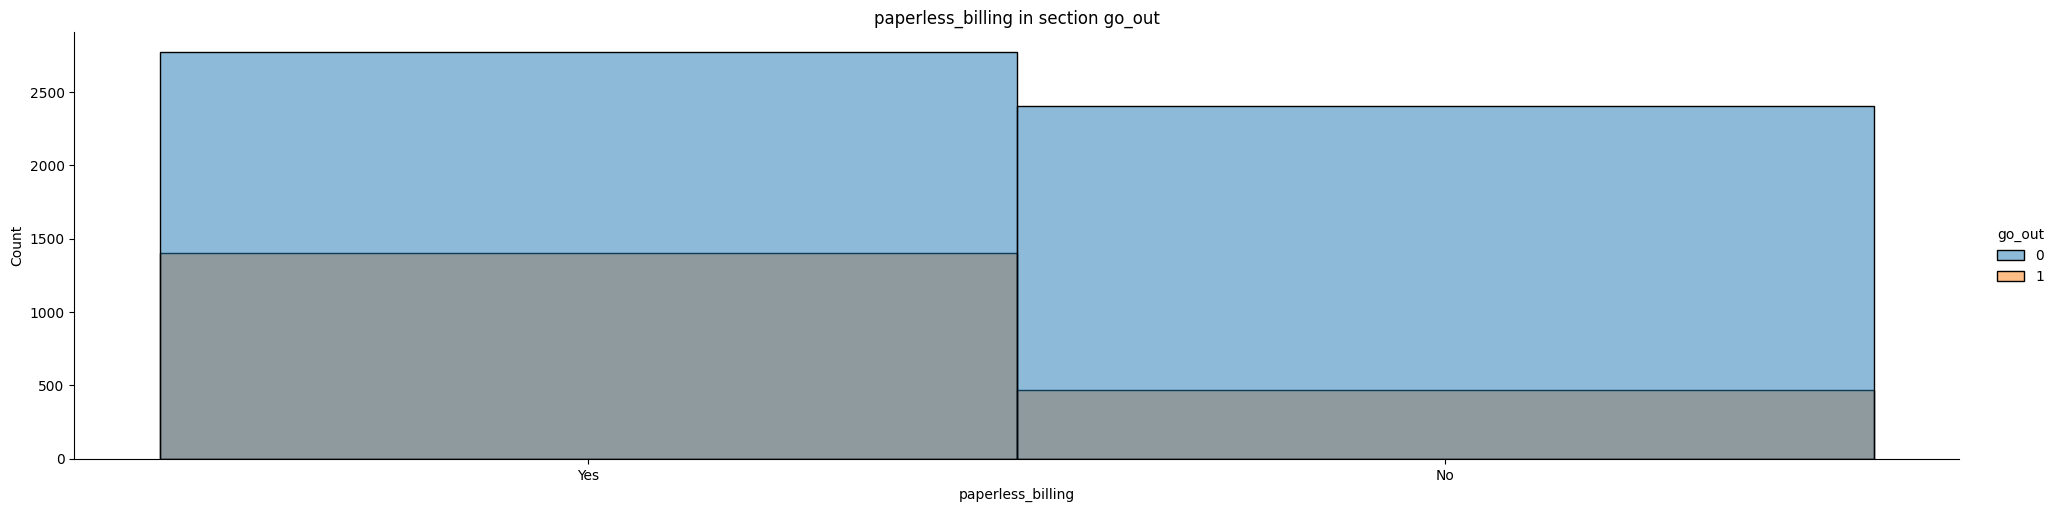

In [68]:
for col_name in [
    "tech_support",
    "online_security",
    "internet_service",
    "dependents",
    "partner",
    "senior_citizen",
    "payment_method",
    "paperless_billing",
]:
    yes_no_plot(col_name)

Как видно из представленных выше графиков и таблиц, среди ушедших клиентов в сравнении с оставшимися, выше доля тех, у кого не было **услуг**: 
- по выделенной линии технической поддержки (83% и 63% соответственно); 
- онлайн антивируса (84% и 66% соответственно); 
- по интернету через DSL (30% и 65% соответственно), то есть клиенты с оптическим подключением уходят чаще. 

Также имеются различия по **демографическим показателям**: 
- бездетные среди ушедших составляют 82, а среди оставшихся 65;
- состоящие в браке среди ушедших составляют 35, а среди оставшихся 52;
- пенсионеры среди ушедших составляют 25, а среди оставшихся 12;

По способам **оплаты**: 
- пользуется Electronic check среди ушедших составляют 58%, а среди оставшихся 25%;
- получатели электронного расчетного листа среди ушедших составляют 74%, а среди оставшихся 53% 

In [69]:
set(columns) - set(
    [
        "tech_support",
        "online_security",
        "internet_service",
        "dependents",
        "partner",
        "senior_citizen",
        "payment_method",
        "paperless_billing",
    ]
)

{'begin_date', 'monthly_charges', 'total_charges'}

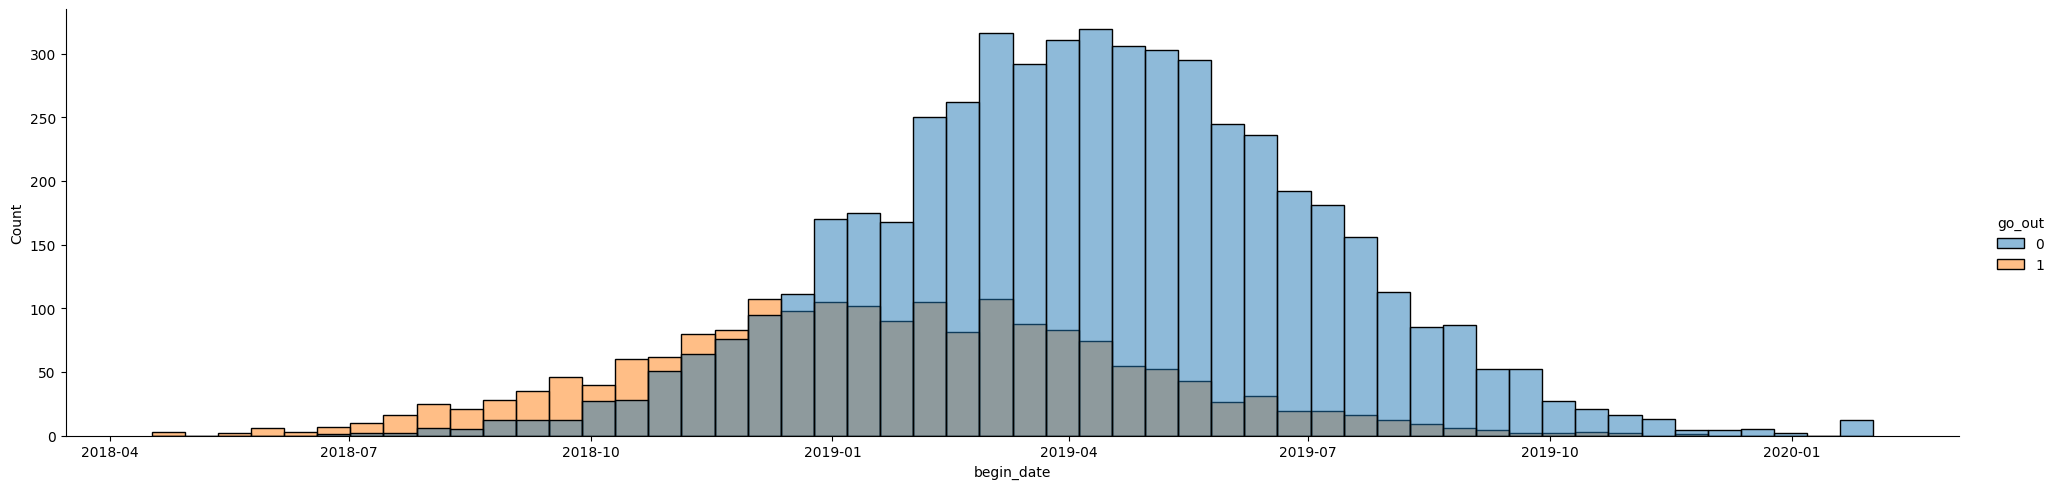

In [70]:
g = sns.displot(
    data=df, x="begin_date", hue="go_out", legend=True, aspect=4, kind="hist", alpha=0.5
)

Для использования в модели выделим в дальнейшем отдельно период использования услуг (в днях). 

In [71]:
pd.pivot_table(df, index="go_out", values="monthly_charges", aggfunc=["sum", "mean"])

sum            mean
       monthly_charges monthly_charges
go_out                                
0            316985.75       61.265124
1            139130.85       74.441332

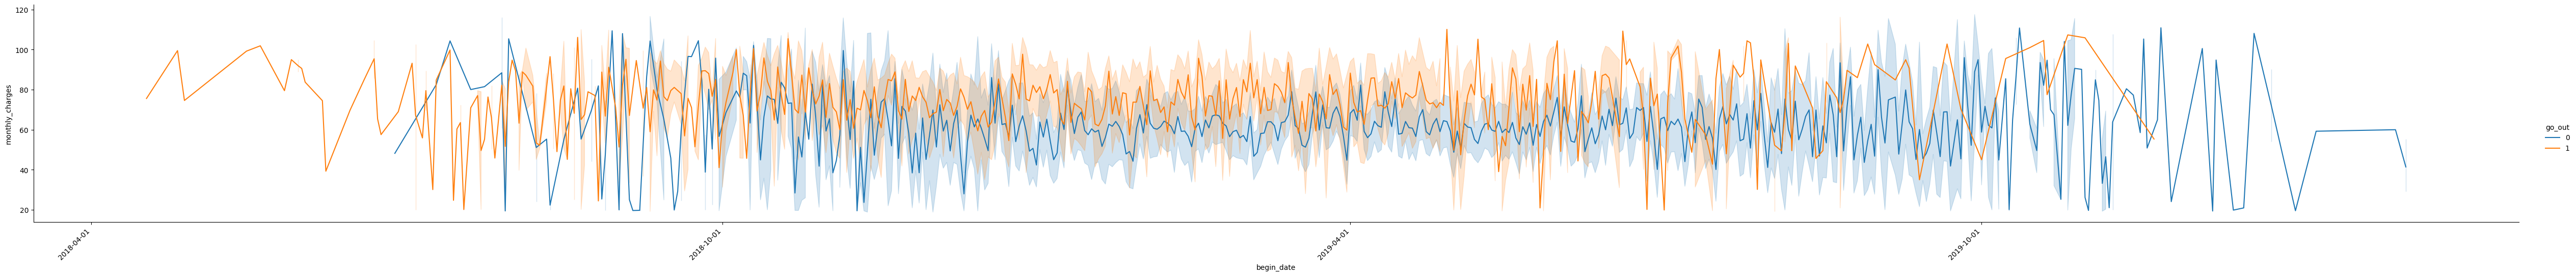

In [72]:
g = sns.relplot(
    data=df.sort_values("begin_date"),
    x="begin_date",
    y="monthly_charges",
    hue="go_out",
    legend=True,
    kind="line",
    aspect=10,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2)

Те, кто уходят в среднем платят больше, однако среди ушедших меньше доля тех, кто пользуется выделенной линией техподдержки и антивирусом, возможно они платят больше за такие же услуги, а возможно это связано с типом соединения.

In [73]:
df_buffer = df[(df.online_security == "No") & (df.tech_support == "No")]
pd.pivot_table(
    df_buffer,
    index="go_out",
    columns="internet_service",
    values="monthly_charges",
    aggfunc=["mean"],
)

mean            
internet_service        DSL Fiber optic
go_out                                 
0                 28.600208   87.085642
1                 37.337755   85.291195

In [74]:
df_buffer = df[(df.online_security == "Yes") & (df.tech_support == "Yes")]
pd.pivot_table(
    df_buffer,
    index="go_out",
    columns="internet_service",
    values="monthly_charges",
    aggfunc=["mean"],
)

mean            
internet_service        DSL Fiber optic
go_out                                 
0                 69.296907  105.847040
1                 63.973913  105.027358

Как видно из представленных выше таблиц клиенты с оптическим подключением платят гораздо больше, чем подключенные по DSL. Скорее всего в регионах, где проведена оптика более развитая инфраструктура и выше конкуренция. 

В тоже время разницы в платежах среди ушедших и оставшихся не имеется. 


In [75]:
pd.pivot_table(df, index="go_out", values="total_charges", aggfunc=["sum", "mean"])

sum          mean
       total_charges total_charges
go_out                            
0         13193697.4   2549.999497
1          2862926.9   1531.796094

Из исследовательского анализа данных можно сделать следующие выводы: 

Среди ушедших клиентов в сравнении с оставшимися, выше доля тех, у кого не было **услуг**: 
- по выделенной линии технической поддержки (83% и 63% соответственно); 
- онлайн антивируса (84% и 66% соответственно); 
- по интернету через DSL (30% и 65% соответственно), то есть клиенты с оптическим подключением уходят чаще. 

Также имеются различия по **демографическим показателям**: 
- бездетные среди ушедших составляют 82, а среди оставшихся 65;
- состоящие в браке среди ушедших составляют 35, а среди оставшихся 52;
- пенсионеры среди ушедших составляют 25, а среди оставшихся 12;

По способам **оплаты**: 
- пользуется Electronic check среди ушедших составляют 58%, а среди оставшихся 25%;
- получатели электронного расчетного листа среди ушедших составляют 74%, а среди оставшихся 53% 

Клиенты которые ушли платили в среднем столько же сколько и оставшиеся. 

Возможно клиенты с оптическим подключением уходят чаще из-за большей конкуренции среди других компаний.  

## Обучим модель

### Catboost

In [76]:
# создадим новый признак
df["count_days"] = df["begin_date"].rsub(pd.Timestamp("2020-02-01")).dt.days

columns = [
    "tech_support",
    "online_security",
    "internet_service",
    "dependents",
    "partner",
    "senior_citizen",
    "total_charges",
    "monthly_charges",
    "payment_method",
    "paperless_billing",
    "count_days",
]

In [77]:
X = df[columns]
y = df["go_out"]
cat = [
    "tech_support",
    "online_security",
    "internet_service",
    "dependents",
    "partner",
    "senior_citizen",
    "payment_method",
    "paperless_billing",
]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, random_state=int(RANDOM_STATE), test_size=0.25
)

X_train_select, X_valid, y_train_select, y_valid = train_test_split(
    X_train,
    y_train,
    shuffle=True,
    stratify=y_train,
    random_state=int(RANDOM_STATE),
    test_size=0.25,
)

Для начала проведем фич селектион

In [79]:
model = CatBoostClassifier(
    iterations=30000,
    verbose=False,
    task_type="GPU",
    devices="0",
    boosting_type="Ordered",
    leaf_estimation_method="Newton",
    auto_class_weights="Balanced",
    eval_metric="AUC",
    early_stopping_rounds=500,
    random_seed=int(RANDOM_STATE),
    cat_features=cat,
    border_count=254
)

<Axes: >

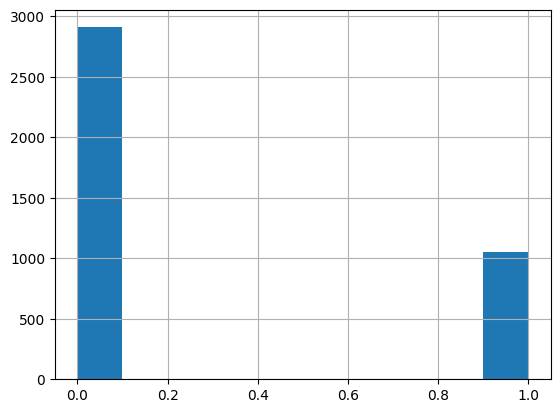

In [80]:
y_train_select.hist()

In [81]:
summary = model.select_features(
    X_train_select,
    y_train_select,
    eval_set=(X_valid, y_valid),
    features_for_select="0-10",
    num_features_to_select=1,
    steps=10,
    train_final_model=False,
    logging_level="Silent",
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


Попробуем посмотреть на признаки с помощью Shape

In [82]:
model.fit(
    X_train_select,
    y_train_select,
    eval_set=(X_valid, y_valid),
    plot=True,    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [83]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0       total_charges    29.202788
1          count_days    26.924803
2    internet_service    15.477437
3     monthly_charges    15.407297
4      payment_method     4.957012
5   paperless_billing     2.226376
6     online_security     1.859287
7      senior_citizen     1.642887
8        tech_support     1.275413
9          dependents     0.647318
10            partner     0.379383

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



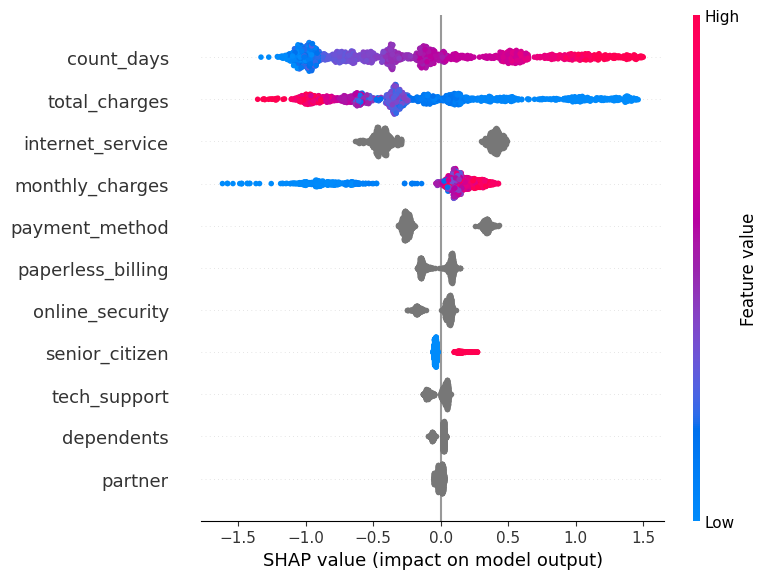

In [84]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_valid, label=y_valid, cat_features=cat)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_valid, max_display=25)

Как видно из работы select_features parther, tech_support, online_security для модели являются шумом (анализ с помощью shape этому не противоречит) , поэтому при переборе гиперпараметров исключим эти признаки.

### Решающее дерево

In [85]:
columns = [
    "internet_service",
    "dependents",
    "senior_citizen",
    "total_charges",
    "monthly_charges",
    "payment_method",
    "paperless_billing",
    "count_days",
]

cat = [
    "internet_service",
    "dependents",
    "senior_citizen",
    "payment_method",
    "paperless_billing",
]

num = ["total_charges", "monthly_charges", "count_days"]

X_train = X_train[columns]
X_train_select = X_train_select[columns]
X_valid = X_valid[columns]
X_test = X_test[columns]

In [86]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num_transform", numeric_transformer, num),
        ("cat_transform", categorical_transformer, cat),
    ]
)


pipeline = Pipeline([("preprocessor", preprocessor), ("clf", RandomForestClassifier())])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_charges',
                                                   'monthly_charges',
                                                   'count_days']),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['internet_service',
                                                   'dependents',
                                                   'senior_citizen',
                                                   'payment_method',
                                                   'paperless_billing'])])),
                ('clf', RandomForestClassifier())])

In [87]:
param = [{"clf__n_estimators": [250, 500], "clf__max_depth": [10, 5]}]

grid_search_third = GridSearchCV(
    pipeline, param, cv=5, n_jobs=-1, scoring=["roc_auc"], refit="roc_auc"
)
grid_search_third.fit(X_train, y_train)

print("Лучшие параметры:")
print(grid_search_third.best_params_)
print("Лучшая метрика на валидационных данных:")
print(grid_search_third.best_score_)

Лучшие параметры:
{'clf__max_depth': 10, 'clf__n_estimators': 500}
Лучшая метрика на валидационных данных:
0.8632238409268392


### Catboost

In [88]:
model_catboost = CatBoostClassifier(
    iterations=3000,
    cat_features=cat,
    logging_level="Silent",
    random_seed=int(RANDOM_STATE),
    task_type="GPU",
    devices=["0"],
    boosting_type="Ordered",
    leaf_estimation_method="Newton",
    early_stopping_rounds=300,
    eval_metric="AUC",
    border_count=254, 
    auto_class_weights = 'Balanced'
)
param = {"l2_leaf_reg": [0.05, 0.1], "depth": [4, 6], "learning_rate": [0.03]}

grid_search = model_catboost.grid_search(
    param,
    X=X_train,
    y=y_train,
    train_size=0.8,
    refit=True,
    cv=5,
    calc_cv_statistics=True,
    plot=True,
)

Default metric period is 5 because AUC is/are not implemented for GPU


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8813395	best: 0.8813395 (0)	total: 8.99s	remaining: 27s


Default metric period is 5 because AUC is/are not implemented for GPU


Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8820773	best: 0.8820773 (1)	total: 17.6s	remaining: 17.6s


Default metric period is 5 because AUC is/are not implemented for GPU


Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8794076	best: 0.8820773 (1)	total: 25.4s	remaining: 8.48s


Default metric period is 5 because AUC is/are not implemented for GPU


Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8807862	best: 0.8820773 (1)	total: 37.3s	remaining: 0us
Estimating final quality...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


### Tabnet

In [89]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num_transform", numeric_transformer, num),
        ("cat_transform", categorical_transformer, cat),
    ]
)


pipeline = Pipeline([("preprocessor", preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_charges',
                                                   'monthly_charges',
                                                   'count_days']),
                                                 ('cat_transform',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['internet_service',
                                                   'dependents',
                                                   'senior_citizen',
                                                   'payment_method',
                                                   'paperless_billing'])]))])

In [90]:
X_train_tab_net = pipeline.fit_transform(X_train_select)
X_valid_tab_net = pipeline.fit_transform(X_valid)

In [91]:
cat_idxs = [i for i in range(4, 15)]
cat_dims = [2 for i in range(len(cat_idxs))]


unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",
    n_shared_decoder=1,
    n_indep_decoder=1,
    verbose=100,
)

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda



In [92]:
unsupervised_model.fit(
    X_train=X_train_tab_net,
    eval_set=[X_valid_tab_net],
    max_epochs=3000,
    patience=100,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 231.54262| val_0_unsup_loss_numpy: 9.692770004272461|  0:00:01s
epoch 100| loss: 0.27747 | val_0_unsup_loss_numpy: 0.2374899983406067|  0:00:28s
epoch 200| loss: 0.11995 | val_0_unsup_loss_numpy: 0.08940000087022781|  0:00:53s
epoch 300| loss: 0.06559 | val_0_unsup_loss_numpy: 0.05355000123381615|  0:01:19s

Early stopping occurred at epoch 371 with best_epoch = 271 and best_val_0_unsup_loss_numpy = 0.04526999965310097


/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



In [93]:
best_metric = float("inf")
best_model_net = None
for mask_type in ["entmax", "sparsemax"]:
    for gamma in [0.5, 0.9]:
        model_tab = TabNetClassifier(
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-3),
            scheduler_params={"step_size": 5, "gamma": gamma},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type=mask_type,
            verbose=100,
        )

        model_tab.fit(
            X_train=X_train_tab_net,
            y_train=np.array(y_train_select).reshape(-1),
            eval_set=[
                (X_train_tab_net, np.array(y_train_select).reshape(-1)),
                (X_valid_tab_net, np.array(y_valid).reshape(-1)),
            ],
            eval_name=["train", "valid"],
            eval_metric=["auc"],
            max_epochs=3000,
            patience=100,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            from_unsupervised=unsupervised_model,
        )

        predict = model_tab.predict(X_valid_tab_net)
        metric = roc_auc_score(y_valid, predict)
        print(metric, mask_type, gamma)
        if metric < best_metric:
            best_metric = metric
            best_model_net = copy.deepcopy(model_tab)
            best_param = (mask_type, gamma)
print("Лучшая метрика:", best_metric)
print("Лучшие гиперпараметры:", best_param)

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_dims changed from [] to [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_emb_dim changed from 1 to 5

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_idxs changed from [] to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning:

Loading weights from unsupervised pretraining



epoch 0  | loss: 0.83063 | train_auc: 0.62518 | valid_auc: 0.62862 |  0:00:00s
epoch 100| loss: 0.49886 | train_auc: 0.76163 | valid_auc: 0.73534 |  0:00:37s

Early stopping occurred at epoch 143 with best_epoch = 43 and best_valid_auc = 0.73889
0.6261227127206509 entmax 0.5


/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_dims changed from [] to [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_emb_dim changed from 1 to 5

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_idxs changed from [] to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


epoch 0  | loss: 0.83063 | train_auc: 0.62518 | valid_auc: 0.62862 |  0:00:00s
epoch 100| loss: 0.43686 | train_auc: 0.83067 | valid_auc: 0.78236 |  0:00:40s
epoch 200| loss: 0.43234 | train_auc: 0.83616 | valid_auc: 0.78828 |  0:01:19s
epoch 300| loss: 0.43018 | train_auc: 0.83688 | valid_auc: 0.78882 |  0:01:56s

Early stopping occurred at epoch 382 with best_epoch = 282 and best_valid_auc = 0.78957
0.6721385144065556 entmax 0.9


/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_dims changed from [] to [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_emb_dim changed from 1 to 5

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_idxs changed from [] to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


epoch 0  | loss: 0.83063 | train_auc: 0.62518 | valid_auc: 0.62862 |  0:00:00s
epoch 100| loss: 0.49886 | train_auc: 0.76163 | valid_auc: 0.73534 |  0:00:37s

Early stopping occurred at epoch 143 with best_epoch = 43 and best_valid_auc = 0.73889
0.6261227127206509 sparsemax 0.5


/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cuda

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_dims changed from [] to [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_emb_dim changed from 1 to 5

/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning:

Pretraining: cat_idxs changed from [] to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


epoch 0  | loss: 0.83063 | train_auc: 0.62518 | valid_auc: 0.62862 |  0:00:00s
epoch 100| loss: 0.43686 | train_auc: 0.83067 | valid_auc: 0.78236 |  0:00:40s
epoch 200| loss: 0.43234 | train_auc: 0.83616 | valid_auc: 0.78828 |  0:01:19s
epoch 300| loss: 0.43018 | train_auc: 0.83688 | valid_auc: 0.78882 |  0:01:56s

Early stopping occurred at epoch 382 with best_epoch = 282 and best_valid_auc = 0.78957
0.6721385144065556 sparsemax 0.9
Лучшая метрика: 0.6261227127206509
Лучшие гиперпараметры: ('entmax', 0.5)


/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-DLBhbz7H-py3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



Модель с лучшей метрикой catboost, поэтому далее будем анализировать ее работу. 

In [94]:
pred_for_test = model_catboost.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, pred_for_test)
print("auc_score", round(auc_score, 2))

auc_score 0.89


Метрика больше 0.85, поэтому заданная цель достигнута. 

Прежде чем применять измерять точность, подберем порог на тестовых данных.

In [95]:
pred_for_test = model_catboost.predict(X_test)
score = accuracy_score(y_test, pred_for_test)
print("accuracy score:", round(score, 2))

accuracy score: 0.8


Точность модели составляет 0.8, а значит она интерпретируема.

Построем матрицу ошибок, графики полноты и точности.

In [96]:
def plot_confusion_matrix(
    X: list[int] = [],
    y: list[int] = [],
    size: tuple[int, int] = (10, 8),
) -> object:
    matrix = confusion_matrix(X, y)
    plt.figure(figsize=size)
    classes = [
        "True Negative",
        "False Positive",
        "False Negative",
        "True Positive",
    ]
    values = ["{0:0.0f}".format(x) for x in matrix.flatten()]
    percentages = ["{0:.1%}".format(x) for x in matrix.flatten() / np.sum(matrix)]
    combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
    combined = np.asarray(combined).reshape(2, 2)
    plot = sns.heatmap(matrix, annot=combined, fmt="", cmap="YlGnBu")
    plot.set(title="Confusion Matrix")
    plot.set(xlabel="Predicted", ylabel="Actual")

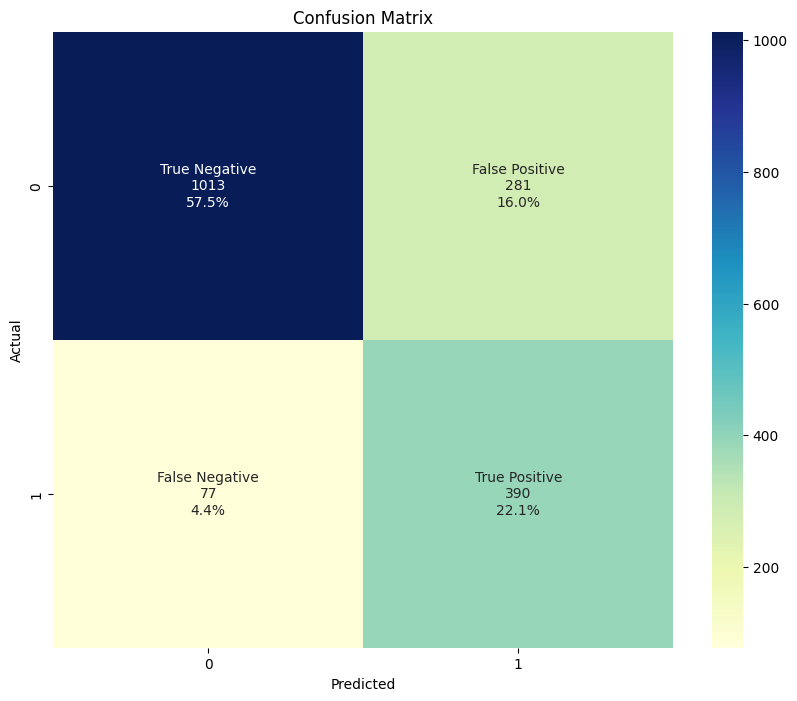

In [105]:
plot_confusion_matrix(y_test, pred_for_test)

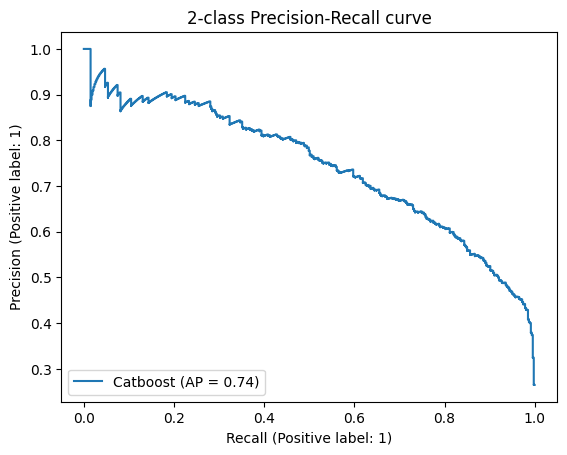

In [107]:
display = PrecisionRecallDisplay.from_estimator(
    model_catboost, X_test, y_test, name="Catboost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [108]:
model_catboost.get_feature_importance(prettified=True)

Feature Id  Importances
0      total_charges    30.078375
1         count_days    25.510221
2    monthly_charges    23.695936
3   internet_service    10.103452
4     payment_method     6.638442
5  paperless_billing     1.691113
6     senior_citizen     1.510068
7         dependents     0.772392

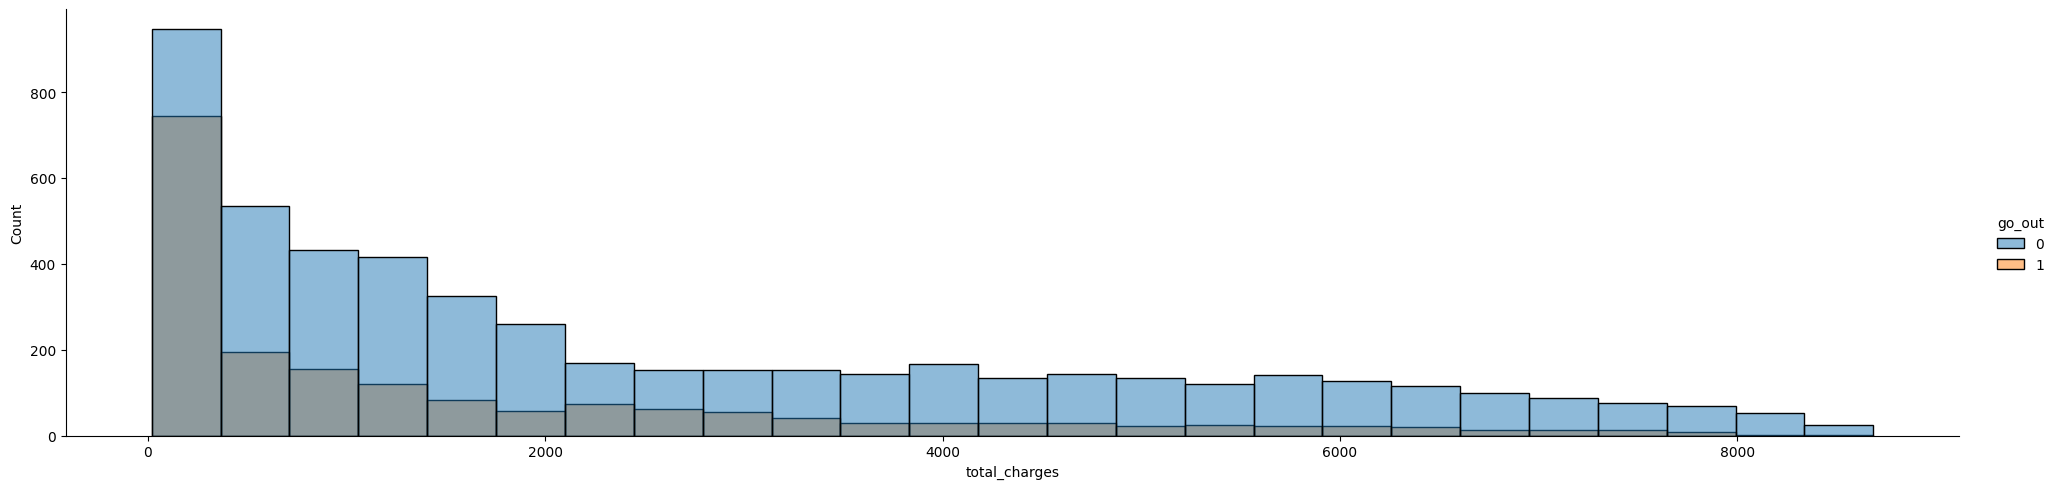

In [109]:
g = sns.displot(
    data=df, x="total_charges", hue="go_out", legend=True, aspect=4, kind="hist", alpha=0.5
)

Чем меньше человек заплатил денег компании в общем, тем скорее он расторгнет договор, возможно их не устраивает качество и количество предоставляемых базовых услуг. 

In [113]:
y_train.value_counts()

go_out
0    3880
1    1402
Name: count, dtype: int64

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий студента <a class="tocSkip"></h2>

Осуществим константное предсказание и расчитаем метрику accuracy. За константу возьмем факт того что клиент остался, так как таких случаем больше.

In [114]:
pred_for_test = model_catboost.predict(X_test)
score = accuracy_score(y_test, [0]*len(y_test))
print("constant accuracy score:", round(score, 2))

constant accuracy score: 0.73


Предсказание модели лучше констатного

## Вывод

В ходе работы удалось обучень модель с показателями 0.9 по метрике auc и 0.8 по метрике accuracy на тестовых данных. 

Кроме того, из исследовательского анализа данных можно сделать следующие выводы: 

Среди ушедших клиентов в сравнении с оставшимися, выше доля тех, у кого не было **услуг**: 
- по выделенной линии технической поддержки (83% и 63% соответственно); 
- онлайн антивируса (84% и 66% соответственно); 
- по интернету через DSL (30% и 65% соответственно), то есть клиенты с оптическим подключением уходят чаще. 

Также имеются различия по **демографическим показателям**: 
- бездетные среди ушедших составляют 82, а среди оставшихся 65;
- состоящие в браке среди ушедших составляют 35, а среди оставшихся 52;
- пенсионеры среди ушедших составляют 25, а среди оставшихся 12;

По способам **оплаты**: 
- пользуется Electronic check среди ушедших составляют 58%, а среди оставшихся 25%;
- получатели электронного расчетного листа среди ушедших составляют 74%, а среди оставшихся 53% 

Клиенты которые ушли платили в среднем столько же сколько и оставшиеся. 

Возможно клиенты с оптическим подключением уходят чаще из-за большей конкуренции среди других компаний.  